# Project Capstone - I94 Immigration Data
## Data Engineering Capstone Project

#### Project Summary
This Project creates a Data Warehouse type of ETL pipeline to process, clean and store data related to US I94 Immigration data. Data can be used to analyse immigration flow to and from US through different airports.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Import necessary libraries
import os, re
import configparser
import pandas as pd
import psycopg2
import datetime as dt
import boto3
from sql_queries import copy_table_queries, insert_table_queries, list_all_tables

from IPython.display import Image
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql.types import StructField, StructType, IntegerType, DoubleType, DateType, StringType
from pyspark.sql.functions import count, split, explode, udf, col, when, lower, isnull, year, month, dayofmonth, hour, weekofyear, dayofweek, date_format, to_date, datediff

## Step 1: Scope the Project and Gather Data

### Scope 
We will create a Data Warehouse on AWS for other data scientists can analyze the data and find insights in it.

### Describe and Gather Data 
In this project we use immigration data sets, demographic data sets, airport and the descriptions contained in the file I94_SAS_Labels_Descriptions.SAS.

In [2]:
config = configparser.ConfigParser()
config.read('dwh.cfg')
os.environ['AWS_ACCESS_KEY_ID']=config['AWS']['key']
os.environ['AWS_SECRET_ACCESS_KEY']=config['AWS']['secret']

In [3]:
spark = SparkSession.builder\
    .config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11,org.apache.hadoop:hadoop-aws:2.7.0")\
    .enableHiveSupport().getOrCreate()

In [4]:
# Load data immigration
df_imigration_i94 =spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')
df_imigration_i94.head(1)

[Row(cicid=6.0, i94yr=2016.0, i94mon=4.0, i94cit=692.0, i94res=692.0, i94port='XXX', arrdate=20573.0, i94mode=None, i94addr=None, depdate=None, i94bir=37.0, i94visa=2.0, count=1.0, dtadfile=None, visapost=None, occup=None, entdepa='T', entdepd=None, entdepu='U', matflag=None, biryear=1979.0, dtaddto='10282016', gender=None, insnum=None, airline=None, admnum=1897628485.0, fltno=None, visatype='B2')]

In [5]:
# Load data airport
airport = spark.read.format('csv').options(header='true', inferSchema='true').load('airport-codes_csv.csv')
airport.head(1)

[Row(ident='00A', type='heliport', name='Total Rf Heliport', elevation_ft=11, continent='NA', iso_country='US', iso_region='US-PA', municipality='Bensalem', gps_code='00A', iata_code=None, local_code='00A', coordinates='-74.93360137939453, 40.07080078125')]

In [6]:
# Define schema for demographics
schema_demographics = StructType([
    StructField('city', StringType()),
    StructField('state', StringType()),
    StructField('media_age', DoubleType()),
    StructField('male_population', IntegerType()),
    StructField('female_population', IntegerType()),
    StructField('total_population', IntegerType()),
    StructField('number_of_veterans', IntegerType()),
    StructField('foreign_born', IntegerType()),
    StructField('average_household_size', DoubleType()),
    StructField('state_code', StringType()),
    StructField('race', StringType()),
    StructField('count', IntegerType())
])

In [7]:
# Load data airport
df_us_cities_demographics = spark.read.format('csv')\
                                .options(header='true', delimiter=';')\
                                .schema(schema_demographics)\
                                .load('us-cities-demographics.csv')
df_us_cities_demographics.head(1)

[Row(city='Silver Spring', state='Maryland', media_age=33.8, male_population=40601, female_population=41862, total_population=82463, number_of_veterans=1562, foreign_born=30908, average_household_size=2.6, state_code='MD', race='Hispanic or Latino', count=25924)]

In [8]:
# Load data i94cit_i94res
i94cit_i94res = []
with open('i94cit_i94res.txt') as f:
    for line in f:
        ln = re.split(r'=', line, maxsplit=1)
        i94cit_i94res.append({'i94cit_res_id': ln[0].strip(), 'country': ln[1].strip()[1:-1]})

df_i94cit_i94res = spark.sparkContext.parallelize(i94cit_i94res)
df_i94cit_i94res = spark.read.json(df_i94cit_i94res)
df_i94cit_i94res = df_i94cit_i94res.select(['i94cit_res_id', 'country'])
df_i94cit_i94res.head(1)

[Row(i94cit_res_id='582', country='MEXICO Air Sea, and Not Reported (I-94, no land arrivals)')]

In [9]:
# Load data i94port
i94port = []
with open('i94port.txt') as f:
    for line in f:
        ln = re.split(r'=', line, maxsplit=1)
        i94port.append({'code': ln[0].strip()[1:-1], 'description': ln[1].strip()[1:-1].strip()})
        
df_i94port = spark.sparkContext.parallelize(i94port)
df_i94port = spark.read.json(df_i94port)
df_i94port.head(1)

[Row(code='ALC', description='ALCAN, AK')]

In [10]:
# Load data i94mode
i94mode = []
with open('i94mode.txt') as f:
    for line in f:
        ln = re.split(r'=', line, maxsplit=1)
        i94mode.append({'code': ln[0].strip(), 'mode': ln[1].strip()[1:-1]})
        
df_i94mode = spark.sparkContext.parallelize(i94mode)
df_i94mode = spark.read.json(df_i94mode)
df_i94mode.head(1)

[Row(code='1', mode='Air')]

In [11]:
# Load data i94addr
i94addr = []
with open('i94addr.txt') as f:
    for line in f:
        ln = re.split(r'=', line, maxsplit=1)
        i94addr.append({'i94addr_id': ln[0].strip()[1:-1], 'state': ln[1].strip()[1:-1].strip()})

df_i94addr = spark.sparkContext.parallelize(i94addr)
df_i94addr = spark.read.json(df_i94addr)
df_i94addr.head(1)

[Row(i94addr_id='AL', state='ALABAMA')]

In [12]:
# Load data i94visa
i94visa = []
with open('i94visa.txt') as f:
    for line in f:
        ln = re.split(r'=', line, maxsplit=1)
        i94visa.append({'code': ln[0].strip(), 'category': ln[1].strip()})

df_i94visa = spark.sparkContext.parallelize(i94visa)
df_i94visa = spark.read.json(df_i94visa)
df_i94visa = df_i94visa.select(['code', 'category'])
df_i94visa.head(1)

[Row(code='1', category='Business')]

## Step 2: Explore and Assess the Data

### Immigration data

I-94 is a small white paper form that a foreign visitor received from cabin crews on arrival flights and from US Customs upon entry into the United States. It contains information such as the traveler's immigration category, United States entry data, status expiration date, port of entry and unique identification number.

### Airport Data

The list with the airport code was provided, it is contained in airport-codes_csv.csv, in this file we have relevant data such as location, airport type, location and etc.

### US city demographics

Dataset contains demographic information for all US cities.

### Explore the Data 

Identify missing values etc.

In [13]:
# Missing values df_imigration_i94
df_imigration_i94.select([count(when(col(c).isNull(), c)).alias(c) for c in df_imigration_i94.columns]).show()

+-----+-----+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-------+-------+-------+-------+-------+-------+-------+------+-------+-------+------+-----+--------+
|cicid|i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|  occup|entdepa|entdepd|entdepu|matflag|biryear|dtaddto|gender| insnum|airline|admnum|fltno|visatype|
+-----+-----+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-------+-------+-------+-------+-------+-------+-------+------+-------+-------+------+-----+--------+
|    0|    0|     0|     0|     0|      0|      0|    239| 152592| 142457|   802|      0|    0|       1| 1881250|3088187|    238| 138429|3095921| 138429|    802|    477|414269|2982605|  83627|     0|19549|       0|
+-----+-----+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-------+-------+-------+---

In [14]:
# Missing values airport
airport.select([count(when(col(c).isNull(), c)).alias(c) for c in airport.columns]).show()

+-----+----+----+------------+---------+-----------+----------+------------+--------+---------+----------+-----------+
|ident|type|name|elevation_ft|continent|iso_country|iso_region|municipality|gps_code|iata_code|local_code|coordinates|
+-----+----+----+------------+---------+-----------+----------+------------+--------+---------+----------+-----------+
|    0|   0|   0|        7006|        0|          0|         0|        5676|   14045|    45886|     26389|          0|
+-----+----+----+------------+---------+-----------+----------+------------+--------+---------+----------+-----------+



In [15]:
# Missing values df_us_cities_demographics
df_us_cities_demographics.select([count(when(col(c).isNull(), c)).alias(c) for c in df_us_cities_demographics.columns]).show()

+----+-----+---------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+----+-----+
|city|state|media_age|male_population|female_population|total_population|number_of_veterans|foreign_born|average_household_size|state_code|race|count|
+----+-----+---------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+----+-----+
|   0|    0|        0|              3|                3|               0|                13|          13|                    16|         0|   0|    0|
+----+-----+---------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+----+-----+



In [16]:
# Missing values df_i94cit_i94res
df_i94cit_i94res.select([count(when(col(c).isNull(), c)).alias(c) for c in df_i94cit_i94res.columns]).show()

+-------------+-------+
|i94cit_res_id|country|
+-------------+-------+
|            0|      0|
+-------------+-------+



In [17]:
# Missing values df_i94port
df_i94port.select([count(when(col(c).isNull(), c)).alias(c) for c in df_i94port.columns]).show()

+----+-----------+
|code|description|
+----+-----------+
|   0|          0|
+----+-----------+



In [18]:
# Missing values df_i94mode
df_i94mode.select([count(when(col(c).isNull(), c)).alias(c) for c in df_i94mode.columns]).show()

+----+----+
|code|mode|
+----+----+
|   0|   0|
+----+----+



In [19]:
# Missing values df_i94addr
df_i94addr.select([count(when(col(c).isNull(), c)).alias(c) for c in df_i94addr.columns]).show()

+----------+-----+
|i94addr_id|state|
+----------+-----+
|         0|    0|
+----------+-----+



In [20]:
# Missing values df_i94visa
df_i94visa.select([count(when(col(c).isNull(), c)).alias(c) for c in df_i94visa.columns]).show()

+----+--------+
|code|category|
+----+--------+
|   0|       0|
+----+--------+



### Cleaning Steps

Document steps necessary to clean the data: drop/clean Null, wrong datatype, ...

In [21]:
# Clean tasks airport
airport = airport.withColumn('latitude', split(col('coordinates'), ',')[1])
airport = airport.withColumn('longitude', split(col('coordinates'), ',')[0])
airport = airport.withColumn('state', split(col('iso_region'), '-')[1])

# Filter airport by country
airport.filter(airport['iso_country'] == 'US')

# Filter by local code is not null
airport = airport.filter(airport['local_code'].isNotNull())

# Drop columns
airport = airport.drop('iso_region').drop('coordinates').drop('elevation_ft').drop('municipality').drop('gps_code').drop('iata_code')

In [22]:
# Clean tasks cities 
df_us_cities_demographics = df_us_cities_demographics.where(col('state').isNotNull()).dropDuplicates(['state', 'city', 'race'])

# Columns for groupby
us_columns_groupby = ['city', 'state', 'state_code']

# Create object for agg
_agg = {
    'media_age': 'first',
    'male_population': 'first',
    'female_population': 'first',
    'total_population': 'first',
    'number_of_veterans': 'first',
    'foreign_born': 'first',
    'average_household_size': 'first'
}

# First groupby
df_us_agg = df_us_cities_demographics.groupby(us_columns_groupby).agg(_agg)

# Pivot transform values of the column race to columns
df_us_pv = df_us_cities_demographics.groupby(us_columns_groupby).pivot('race').sum('count')

# Join df_us_agg with df_us_pv
df_us_cities_demographics = df_us_agg.join(other=df_us_pv, on=us_columns_groupby, how='inner')

# Rename columns
df_us_cities_demographics = df_us_cities_demographics.withColumnRenamed('first(foreign_born)', 'foreign_born')\
    .withColumnRenamed('first(male_population)', 'male_population')\
    .withColumnRenamed('first(average_household_size)', 'average_household_size')\
    .withColumnRenamed('first(total_population)', 'total_population')\
    .withColumnRenamed('first(female_population)', 'female_population')\
    .withColumnRenamed('first(media_age)', 'media_age')\
    .withColumnRenamed('first(number_of_veterans)', 'number_of_veterans')\
    .withColumnRenamed('American Indian and Alaska Native', 'american_indian_and_alaska_native')\
    .withColumnRenamed('Asian', 'asian')\
    .withColumnRenamed('Black or African-American', 'black_or_african_american')\
    .withColumnRenamed('Hispanic or Latino', 'hispanic_or_latino')\
    .withColumnRenamed('White', 'white')

# List of columns int
us_cities_demographics_columns_int = ['foreign_born', 'male_population', 'average_household_size', \
                                      'female_population', 'number_of_veterans', \
                                      'american_indian_and_alaska_native', 'asian', 'black_or_african_american', 'white']
df_us_cities_demographics = df_us_cities_demographics.na.fill(0, subset=us_cities_demographics_columns_int)

In [23]:
# Clean tasks cities immigration

# Complete with zero(0) columns null
immigration_columns_int = ['cicid','i94yr','i94mon','i94cit','i94res','arrdate','i94bir','count','i94visa','dtadfile','biryear','depdate']
df_imigration_i94 = df_imigration_i94.na.fill(0, subset=immigration_columns_int)

# Function for cast column
def cast_column(df, list_columns, type_column):
    for column in list_columns:
        df = df.withColumn(column, df[column].cast(type_column))
    return df

# Cast column for integer
df_imigration_i94 = cast_column(df_imigration_i94, immigration_columns_int, IntegerType())

# variable content format date
format_date = '%Y-%m-%d'

# Function parse date
def days_to_datetime(nrDays):
    try:
        if (nrDays == 0 or nrDays == None):
            return dt.datetime(1960, 1, 1).date()
        else:
            return dt.datetime(1960, 1, 1).date() + dt.timedelta(days=nrDays)
    except:
        return None
    
# Define udf lambda for parse date
udf_days_to_datetime = udf(lambda nrDays: days_to_datetime(nrDays), DateType())

# Convert column to date YYYY-MM-DD
df_imigration_i94 = df_imigration_i94.withColumn('arrdate', udf_days_to_datetime(df_imigration_i94.arrdate))
df_imigration_i94 = df_imigration_i94.withColumn('depdate', udf_days_to_datetime(df_imigration_i94.depdate))

# Function get day diff date
def diff_date(dt1, dt2):
    if dt1 is None or dt2 == dt.datetime(1960, 1, 1).date():
        return 0
    else:
        diff = dt2 - dt1
        return int(diff.days)

# Define udf lambda get days diff
diff_date_udf = udf(diff_date)

# Get days stay
df_imigration_i94 = df_imigration_i94.withColumn('days_stay', diff_date_udf(df_imigration_i94.arrdate, df_imigration_i94.depdate))

# Cast column for integer
df_imigration_i94 = cast_column(df_imigration_i94, ['days_stay'], IntegerType())

# Update i94mode of value not reported
df_imigration_i94 = df_imigration_i94.na.fill(9, subset=['i94mode'])

# Update i94addr when value is null, set 99
df_imigration_i94 = df_imigration_i94.na.fill('99', subset=['i94addr'])

# Update fltno when value is null, set 0
df_imigration_i94 = df_imigration_i94.na.fill('0', subset=['fltno'])

# Update airline, insnum, gender, matflag when value is null, set None
df_imigration_i94 = df_imigration_i94.na.fill('None', subset=['airline', 'insnum', 'gender', 'matflag'])

# Cast for column i94mode
df_imigration_i94 = cast_column(df_imigration_i94, ['i94mode'], IntegerType())

# Columns to drop
columns_to_drop = ['dtadfile', 'visapost', 'occup', 'entdepa', 'entdepd', 'entdepu', 'dtaddto']  
df_imigration_i94 = df_imigration_i94.drop(*columns_to_drop)

In [24]:
# Cleaning tasks i94port
df_i94port = df_i94port.withColumn('city', split(col('description'), ',')[0])
df_i94port = df_i94port.withColumn('state', split(col('description'), ',')[1])
df_i94port = df_i94port.drop('description')
df_i94port = df_i94port.filter(col('state').isNotNull())

## Step 3: Define the Data Model

### 3.1 Concept Data Model

Map out the conceptual data model and explain reason to chose that model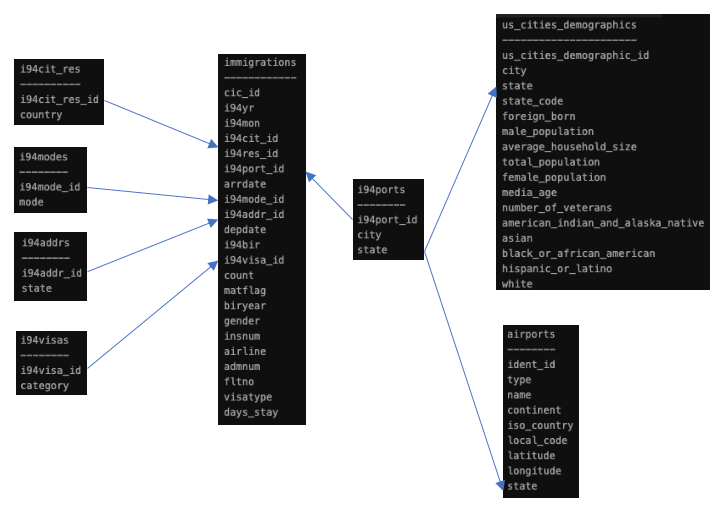

### 3.2 Mapping Out Data Pipelines

List the steps to pipeline the data into the chosen data model

#### Airport data

For the airport data set:

- Create a latitude and longitude columns to store the coordinates of the airports.
- Only filter airports in the United States that were not missing code in the `local_code` column
- Remove the `iso_region`, `coordinates`, `elevation_ft`, `municipality`, `gps_code` and `iata_code` columns


#### US city demographics data

For the airport data set:

- Remove duplicate values through the columns `state`, `city` and `race`
- Create columns with the values contained in the `race` column using the pivot feature
- Complete with zero (0), missing values in the `foreign_born`, `male_population`, `average_household_size`, `female_population`, `number_of_veterans`, `american_indian_and_alaska_native`, `asian`, `black_or_african_american` and `white`


#### Immigration data

For the immigration data set:

- Complete with zero (0), missing values in the `cicid`, `i94yr`, `i94mon`, `i94cit`, `i94res`, `arrdate`, `i94bir`, `count`, `i94visa`, `dtadfile`, `birdyear` and `depdate`
- Create `cast_column` function to cast the required columns
- Create `days_to_datetime` function to parse data 
- Create `diff_date` function to calculate the number of days between the dates contained in the `arrdate` and `depdate` columns. 
- Create a `days_stay` column in this data set to receive the number of days calculated in the `diff_date` function
- Complete missing values in the `i94mode` column
- Complete missing values in column `i94addr`
- Complete missing values in the `fltno` column
- Complete missing values in the `airline`, `insnum`, `gender` and `matflag` columns
- Cast the column `i94mode`
- Remove the columns `dtadfile`, `visapost`, `occup`, `entdepa`, `entdepd`, `entdepu` and `dtaddto`


#### I94port data

For the data set of i94port:

- Separate states and city into separate columns

## Step 4: Run Pipelines to Model the Data 

### 4.1 Create bucket in S3

In [26]:
def create_bucket(config, boto3, bucket_name):
    s3 = boto3.client('s3',
                      region_name=config['AWS']['REGION'],
                      aws_access_key_id=config['AWS']['KEY'],
                      aws_secret_access_key=config['AWS']['SECRET'])
    try:
        s3.create_bucket(Bucket=bucket_name)
        print("The bucket {} created !".format(bucket_name))
    except e:
        print("Error: can't create bucket")
        
if boto3.resource('s3').Bucket(config["S3"]["bucket_name"]).creation_date:
    print("The bucket exists !")
else:
    print("The bucket does not exist")
    create_bucket(config, boto3, config["S3"]["bucket_name"])


The bucket does not exist
The bucket data-engineer-capstone created !


### 4.2 Create parquet file in S3

In [27]:
print('Start creating parquet files')

# create path for bucket
path_bucket = "s3a://{}/{}/".format(config["S3"]["bucket_name"], config["S3"]["path_input_data"])
print('Path for parquet files: {}'.format(path_bucket))

#write to parquet i94visa
print('Creating i94visa.parquet')
df_i94visa.write.parquet(os.path.join(path_bucket, 'i94visa.parquet'), mode='overwrite')

#write to parquet i94port
print('Creating i94port.parquet')
df_i94port.write.parquet(os.path.join(path_bucket, 'i94port.parquet'), mode='overwrite')

#write to parquet i94mode
print('Creating i94mode.parquet')
df_i94mode.write.parquet(os.path.join(path_bucket, 'i94mode.parquet'), mode='overwrite')

#write to parquet i94cit_i94res
print('Creating i94cit_i94res.parquet')
df_i94cit_i94res.write.parquet(os.path.join(path_bucket, 'i94cit_i94res.parquet'), mode='overwrite')

#write to parquet i94addr
print('Creating i94addr.parquet')
df_i94addr.write.parquet(os.path.join(path_bucket, "i94addr.parquet"), mode='overwrite')

#write to parquet airport
print('Creating airport.parquet')
airport.repartition(1).write.parquet(os.path.join(path_bucket, 'airport.parquet'), mode='overwrite')

#write to parquet cities demographics
print('Creating cities_demographics.parquet')
df_us_cities_demographics.repartition(1).write.parquet(os.path.join(path_bucket, 'cities_demographics.parquet'), mode='overwrite')

#write to parquet immigration
print('Creating immigration.parquet')
df_imigration_i94.repartition(1).write.parquet(os.path.join(path_bucket, 'immigration.parquet'), mode='overwrite')

print('Finish creating parquet files')

Start creating parquet files
Path for parquet files: s3a://data-engineer-capstone/input-data/
Creating i94visa.parquet
Creating i94port.parquet
Creating i94mode.parquet
Creating i94cit_i94res.parquet
Creating i94addr.parquet
Creating airport.parquet
Creating cities_demographics.parquet
Creating immigration.parquet
Finish creating parquet files


### 4.3 Create Redshift

In [28]:
!python create_redshift.py

## Creating a Client
print aws region us-west-2
## Creating a new IAM Role
## Attaching Policy
## Get the IAM role ARN
## Create Redshift Cluster
Wait, we are checking the status of your capstone Cluster
Status cluster is: creating
Status cluster is: creating
Status cluster is: creating
Status cluster is: creating
Status cluster is: creating
Status cluster is: creating
Status cluster is: creating
Status cluster is: creating
Status cluster is: creating
Status cluster is: creating
Status cluster is: creating
Status cluster is: creating
Status cluster is: creating
Status cluster is: creating
Status cluster is: available
Redshift cluster capstoneCluster created.
                 Key                                                                                       Value
0  ClusterIdentifier  capstonecluster                                                                           
1  NodeType           dc2.large                                                                            

### 4.4 Create tables

In [29]:
!python create_tables.py

### 4.5 Load data in tables on Redshift

In [30]:
def load_staging_tables(cur, conn):
    for query in copy_table_queries:
        cur.execute(query)
        conn.commit()
        
def insert_tables(cur, conn):
    for query in insert_table_queries:
        cur.execute(query)
        conn.commit()
        
def load_and_insert_data_tables():
    config = configparser.ConfigParser()
    config.read('dwh.cfg')

    conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
    cur = conn.cursor()
    
    load_staging_tables(cur, conn)
    insert_tables(cur, conn)

    conn.close()

In [31]:
load_and_insert_data_tables()

### 4.6 Data Quality Checks

Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness

In [32]:
# Perform quality checks here
def data_quality(config):
    conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
    cur = conn.cursor()
    
    for table in list_all_tables:
        query = 'SELECT COUNT(*) FROM {}.{}'.format(config["DWH"]["dwh_db_schema"], table)
        cur.execute(query)
        result = cur.fetchone()
        print('Quality check table {} returned {} results.'.format(table, result[0]))
        conn.commit()
        
    conn.close()

In [33]:
data_quality(config)

Quality check table us_cities_demographics returned 596 results.
Quality check table immigrations returned 3096313 results.
Quality check table airports returned 28686 results.
Quality check table i94visas returned 3 results.
Quality check table i94ports returned 583 results.
Quality check table i94modes returned 4 results.
Quality check table i94cit_res returned 289 results.
Quality check table i94addrs returned 55 results.


### 4.7 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Table Fact 'immigrations'

In [34]:
# create data dictionary df
dic_I94 = {
    'COLUMN NAME': df_imigration_i94.columns, 
    'DESCRIPTION': [
        'Uniquely identify one record in the dataset',
        '4 digit year',
        'Numeric month',
        '3 digit code of source city for immigration - born country',
        '3 digit code of source country for immigration - residence country',
        'Port addmitted through',
        'Arrival date in the USA',
        'Mode of transportation {1 = Air, 2 = Sea, 3 = Land, 9 = "Not reported"}',
        'State of arrival',
        'Departure date',
        'Age of Respondent in Years',
        'Visa codes collapsed into three categories {1 = Business, 2 = Pleasure, 3 = Student}',
        'Used for summary statistics',
        'Match flag',
        '4 digit year of birth',
        'Gender',
        'INS number',
        'Airline used to arrive in U.S.',
        'Admission number, should be unique and not nullable',
        'Flight number of Airline used to arrive in U.S.',
        'Class of admission legally admitting the non-immigrant to temporarily stay in U.S.',
        'Days stay'
    ]
}
dfI94_description = pd.DataFrame(data=dic_I94)
dfI94_description.style.hide_index()

COLUMN NAME,DESCRIPTION
cicid,Uniquely identify one record in the dataset
i94yr,4 digit year
i94mon,Numeric month
i94cit,3 digit code of source city for immigration - born country
i94res,3 digit code of source country for immigration - residence country
i94port,Port addmitted through
arrdate,Arrival date in the USA
i94mode,"Mode of transportation {1 = Air, 2 = Sea, 3 = Land, 9 = ""Not reported""}"
i94addr,State of arrival
depdate,Departure date


#### Table Dimension 'airports'

In [35]:
# create data dictionary airport
dic_airport = {
    'COLUMN NAME': airport.columns, 
    'DESCRIPTION': [
        'Unique identifier', 
        'Type of the airport', 
        'Airport Name', 
        'Continent', 
        'ISO code of the country of the airport',
        'Local code of the airport', 
        'Coordinates latitude of the airport',
        'Coordinates longitude of the airport',
        'State of the airport'
    ]
}
airport_description = pd.DataFrame(data=dic_airport)
airport_description.style.hide_index()

COLUMN NAME,DESCRIPTION
ident,Unique identifier
type,Type of the airport
name,Airport Name
continent,Continent
iso_country,ISO code of the country of the airport
local_code,Local code of the airport
latitude,Coordinates latitude of the airport
longitude,Coordinates longitude of the airport
state,State of the airport


#### Table Dimension 'us_cities_demographics'

In [36]:
# create data dictionary cities demographics
dic_cities_demographics = {
    'COLUMN NAME': df_us_cities_demographics.columns, 
    'DESCRIPTION': [
        'Name of the city', 
        'US state of the city', 
        'Code of the state of the city', 
        'Number of residents of the city that were not born in the city', 
        'Number of the male population',
        'Average size of the houses in the city',
        'Number of the total population',
        'Number of the female population', 
        'The median of the age of the population',
        'Number of veterans living in the city', 
        'Number of American Indian and Alaska Native', 
        'Number of Asian', 
        'Number of Black or African American', 
        'Number of Hispanic or Latino', 
        'Number of White'
    ]
}
us_cities_demographics_description = pd.DataFrame(data=dic_cities_demographics)
us_cities_demographics_description.style.hide_index()

COLUMN NAME,DESCRIPTION
city,Name of the city
state,US state of the city
state_code,Code of the state of the city
foreign_born,Number of residents of the city that were not born in the city
male_population,Number of the male population
average_household_size,Average size of the houses in the city
total_population,Number of the total population
female_population,Number of the female population
media_age,The median of the age of the population
number_of_veterans,Number of veterans living in the city


#### Table Dimension 'i94cit_res'

In [37]:
# create data dictionary cit & res
dic_cit_res = {
    'COLUMN NAME': df_i94cit_i94res.columns, 
    'DESCRIPTION': [
        'Uniquely identify code country', 
        'Name country'
    ]
}
cit_res_description = pd.DataFrame(data=dic_cit_res)
cit_res_description.style.hide_index()

COLUMN NAME,DESCRIPTION
i94cit_res_id,Uniquely identify code country
country,Name country


#### Table Dimension 'i94ports'

In [38]:
# create data dictionary port
dic_i94port = {
    'COLUMN NAME': df_i94port.columns, 
    'DESCRIPTION': [
        'Uniquely identify code city', 
        'Name city',
        'City abbreviation'
    ]
}
i94port_description = pd.DataFrame(data=dic_i94port)
i94port_description.style.hide_index()

COLUMN NAME,DESCRIPTION
code,Uniquely identify code city
city,Name city
state,City abbreviation


#### Table Dimension 'i94modes'

In [39]:
# create data dictionary mode
dic_i94mode = {
    'COLUMN NAME': df_i94mode.columns, 
    'DESCRIPTION': [
        'Uniquely identify code mode', 
        'Description'
    ]
}
i94mode_description = pd.DataFrame(data=dic_i94mode)
i94mode_description.style.hide_index()

COLUMN NAME,DESCRIPTION
code,Uniquely identify code mode
mode,Description


#### Table Dimension 'i94addrs'

In [40]:
# create data dictionary addr
dic_i94addr = {
    'COLUMN NAME': df_i94addr.columns, 
    'DESCRIPTION': [
        'Uniquely identify addr', 
        'Description'
    ]
}
i94addr_description = pd.DataFrame(data=dic_i94addr)
i94addr_description.style.hide_index()

COLUMN NAME,DESCRIPTION
i94addr_id,Uniquely identify addr
state,Description


#### Table Dimension 'i94visas'

In [41]:
# create data dictionary visa
dic_i94visa = {
    'COLUMN NAME': df_i94visa.columns, 
    'DESCRIPTION': [
        'Uniquely identify code visa', 
        'Description'
    ]
}
i94visa_description = pd.DataFrame(data=dic_i94visa)
i94visa_description.style.hide_index()

COLUMN NAME,DESCRIPTION
code,Uniquely identify code visa
category,Description


### Step 5: Complete Project Write Up

#### Clearly state the rationale for the choice of tools and technologies for the project.

We use technologies and resources available on AWS so that the services used are priced according to use, making it possible to start a small project the way it increases this can be scaled.

Spark - We provide all the necessary resources for working with datasets.

Redshift - column-oriented Data Warehouse that can be easily scaled.

S3 - Easy to use, high availability with security and performance. Use as an intermediate area to store or share data in files before uploading the data to the database.

#### Propose how often the data should be updated and why.

Suggestion would be to update it per month because the data received are separated by month

* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
   - We will configure Spark to enable parallelism and switch to using the EMR feature on AWS, so we can use a cluster manager and increase the number of nodes depending on the needs.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
   - We will automate the pipeline with Airflow so that it runs every day at night
 * The database needed to be accessed by 100+ people.
   - Add more nodes to the existing Redshift cluster if performance of the queries is slow when more users are accessing simultaneously.

## Delete Redshift

In [43]:
# Uncomment line below to delete Redshift Cluster on AWS
#!python remove_redshift.py

## Remove Client Redshift and IAM
## Remove Redshift Cluster capstoneCluster
## Remove Resource Cluster capstoneCluster
## Clean bucket data-engineer-capstone
## Remove bucket data-engineer-capstone
## Bucket data-engineer-capstone delete !
## Remove data config
